# TM10007 Assignment Group 5

Authors: namen studienummer

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/annawalstra/tm10007_Group5.git
!pip install simpleITK

## **Data loading and cleaning**



In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import PCA

# Metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data
data = load_data()
print(f'Original data:')
print(f'The number of spamples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating X and Y 
X = data.loc[:, data.columns != 'label']
Y = data['label']
print(f'Data orientation:')
print(X.head())
print(f'Labels in Y: {Y.head()}')

# Binarize Y labels
y_bin = preprocessing.label_binarize(Y, ['CN','AD'])
y_bin = [i[0] for i in y_bin]
print(f'Labels binarized: {y_bin[:10]}')

# Deleting features with only zeros
X = X.loc[:, (X != 0).any(axis=0)]
print(f'DATA CLEANING')
print(f'Deleting columns filled with zeros:')
print(f'The number of spamples: {len(X.index)}')
print(f'The number of columns: {len(X.columns)}')

# Split the dataset in train and test part
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_bin, test_size=0.2, stratify=y_bin)


Original data:
The number of spamples: 855
The number of columns: 268
Data orientation:
                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 267 columns]
Labels in Y: ID
0_002_S_0413_bl_0    AD
0_002_S_0559_bl_0    AD
0_002_S_0619_bl_0    CN
0_002_S_0685_bl_0    AD
0_002_S_0816_bl_0    CN
Name: label, dtype: object
Labels binarized: [1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
DATA CLEANING
Deleting columns filled with zeros:
The number of spamples: 855
The number of columns: 263


## **FEATURE SCALING**

In [0]:
# FEATURE SCALING

# Options: RobustScaler, StandardScaler, MinMaxScaler

# Perform Shapiro-Wilk Test to check if the data is normally/Gaussian distributed
#from numpy.random import seed
#from numpy.random import randn
#from scipy.stats import shapiro
# seed the random number generator
#seed(1)
# generate univariate observations
#data = X_train
# normality test
#stat, p = shapiro(data)
#print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
#alpha = 0.05
#if p > alpha:
# print('Sample looks Gaussian (fail to reject H0)')
#else:
# print('Sample does not look Gaussian (reject H0)')
# Hier kwam uit dat de sample niet Gaussian is dus verder niet naar gekeken

# Chosen: MinMax scaler (of Standard dus, maar nog niet helemaal duidelijk)
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Feature Selection/Extration** Option 1

L1 and RFE are commented

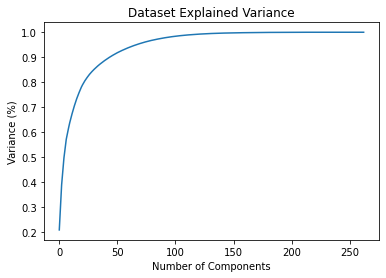

Nr. of components:67


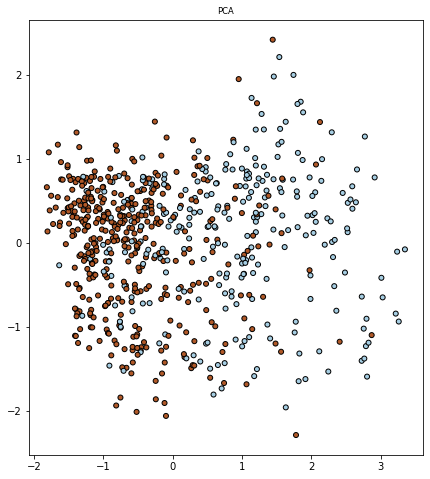

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

# Perform a PCA
var = np.cumsum(pca.explained_variance_ratio_) 
n_components = np.where(var > 0.95)[0][0]
print(f"Nr. of components:{n_components}")

# Perform a PCA
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# # Use the selectfrommodel module: L1 Select all features with a weight above the median.
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Lasso, RidgeClassifier
# selector = SelectFromModel(estimator=Lasso(alpha=10**(-5)), threshold='median')
# selector.fit(X_train_scaled, Y_train)
# n_original = X_train_scaled.shape[1]
# X_train_L1 = selector.transform(X_train_scaled)
# X_test_L1 = selector.transform(X_test_scaled)
# n_selected = X_train_L1.shape[1]
# print(f"Selected {n_selected} from {n_original} features.")

#Plot first feature PCA for visualization
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("PCA", fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=Y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)


# #Plot first feature L1 selection
#fig = plt.figure(figsize=(24,8))
#ax = fig.add_subplot(132)
#ax.set_title("L1", fontsize='small')
#ax.scatter(X_train_L1[:, 0], X_train_L1[:, 1], marker='o', c=Y_train,
        #     s=25, edgecolor='k', cmap=plt.cm.Paired)


# Recursive Feature Elimination (RFE)

# Create the RFE object and compute a cross-validated score
#svc = svm.SVC(kernel="linear")

# classifications
#rfecv = feature_selection.RFECV(
#    estimator=svc, step=1, 
#    cv=model_selection.StratifiedKFold(4),
#    scoring='roc_auc')
#rfecv.fit(X_train_scaled, Y_train)

# Plot number of features VS. cross-validation scores
#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (nb of correct classifications)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.show()


# Crossvalidation for parameter tuning
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

##**FEATURE SELECTION option 2**
## **!!! Run dit alleen als je PCA met RF feature importance wilt toepassen !!!**

First features are selected based on their importance, calculated with a Random Forest classifier.
Secondly, PCA is performed and the remaining features contain 95% of the variance.

(684, 263)


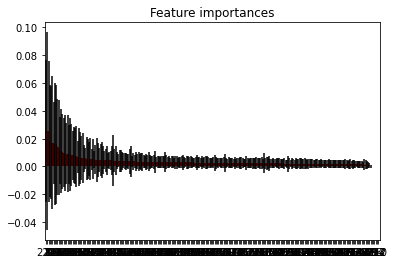

(684, 64)
Nr. of features after RF feature importance:64


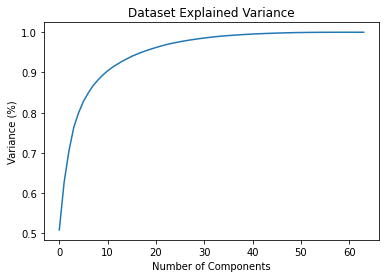

Nr. of features after PCA:23


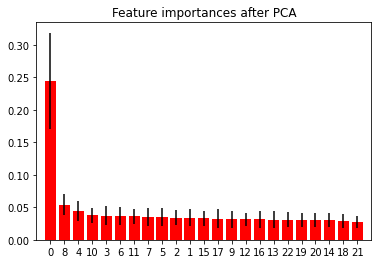

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

print(X_train_scaled.shape)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train_scaled, Y_train)
clf.feature_importances_ 

# Plot the feature importances of the forest
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

model = SelectFromModel(clf, prefit=True, threshold= "1*mean")
X_new = model.transform(X_train_scaled)
X_new_test = model.transform(X_test_scaled)

print(X_new.shape) 
print(f"Nr. of features after RF feature importance:{X_new.shape[1]}")

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_new)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

# Perform a PCA
var = np.cumsum(pca.explained_variance_ratio_) 
n_components = np.where(var > 0.97)[0][0]
print(f"Nr. of features after PCA:{n_components}")

# Perform a PCA
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_new)
X_pca_train = pca.transform(X_new)
X_pca_test = pca.transform(X_new_test)

# Plot importances of PCA selected features
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_pca_train, Y_train)
clf.feature_importances_ 

# Plot the feature importances of the forest
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances after PCA")
plt.bar(range(X_pca_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_pca_train.shape[1]), indices)
plt.xlim([-1, X_pca_train.shape[1]])
plt.show()

## Function **Learning Curve**

In [0]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## KNN Classifier

Waarde voor k wisselt erg vaak!


Best leaf_size: 28
Best p: 2
Best n_neighbors: 32
KNeighborsClassifier(algorithm='auto', leaf_size=28, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.81      0.65      0.73       269
           1       0.80      0.90      0.85       415

    accuracy                           0.81       684
   macro avg       0.81      0.78      0.79       684
weighted avg       0.81      0.81      0.80       684

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        67
           1       0.78      0.83      0.80       104

    accuracy                           0.75       171
   macro avg       0.74      0.73      0.74       171
weighted avg       0.75      0.75      0.75       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

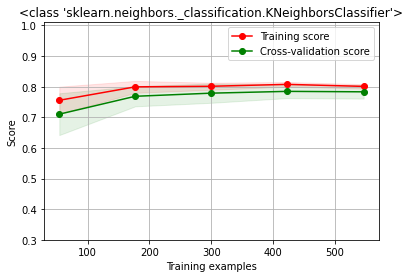

In [0]:
# # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# # Specify the classifier
# knn = neighbors.KNeighborsClassifier()
# parameters = {"n_neighbors": list(range(1, 51, 2))}
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')
# grid_search.fit(X_train_pca, Y_train)
# # Show the complete results of the cross validation
# display(pd.DataFrame(grid_search.cv_results_))


# # # Fit kNN
# # Get resulting classifier
# print(grid_search.best_estimator_)
# #print(f'Best classifier: k={clf.n_neighbors}')
# clf = neighbors.KNeighborsClassifier(n_neighbors=21)
# clf.fit(X_train_pca, Y_train)
# score_train = clf.score(X_train_pca, Y_train)
# score_test = clf.score(X_test_pca, Y_test)

# # Get the accuracy
# y_pred = clf.predict(X_train_pca)
# acc_train=metrics.accuracy_score(Y_train, y_pred)
# y_pred = clf.predict(X_test_pca)
# acc_test=metrics.accuracy_score(Y_test, y_pred)

# # Print result
# print(f"Training result: {score_train}")
# print(f"Test result: {score_test}")
# print(f"Accuracy:")
# print(f"Training result: {acc_train}")
# print(f"Test result: {acc_test}")


#Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,50))
p=[1,2]
hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)

#Create kNN object
knn = neighbors.KNeighborsClassifier()

#Use RandomizedSearch to tune hyperparameters
random_search = model_selection.RandomizedSearchCV(knn, hyperparameters, cv=cv_10fold)

#Fit the model
best_model = random_search.fit(X_train_pca,Y_train)
clf = random_search.best_estimator_

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print(clf)

# Test training dataset
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Test test dataset
y_pred = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred))

#Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)

## KNN with Crossvalidation
De k wisselt heel erg met elke CV, conclusie: erg afhankelijk van training data wat beste k geeft, dus ....??


Iteration nr. 1 with best hyperparameters:
Best leaf_size: 8
Best p: 1
Best n_neighbors: 24
Iteration nr. 2 with best hyperparameters:
Best leaf_size: 45
Best p: 1
Best n_neighbors: 30
Iteration nr. 3 with best hyperparameters:
Best leaf_size: 36
Best p: 1
Best n_neighbors: 34
Iteration nr. 4 with best hyperparameters:
Best leaf_size: 40
Best p: 1
Best n_neighbors: 28
Iteration nr. 5 with best hyperparameters:
Best leaf_size: 12
Best p: 1
Best n_neighbors: 26
Iteration nr. 6 with best hyperparameters:
Best leaf_size: 5
Best p: 1
Best n_neighbors: 27
Iteration nr. 7 with best hyperparameters:
Best leaf_size: 19
Best p: 1
Best n_neighbors: 42
Iteration nr. 8 with best hyperparameters:
Best leaf_size: 3
Best p: 1
Best n_neighbors: 12
Iteration nr. 9 with best hyperparameters:
Best leaf_size: 29
Best p: 1
Best n_neighbors: 16
Iteration nr. 10 with best hyperparameters:
Best leaf_size: 35
Best p: 1
Best n_neighbors: 9
Iteration nr. 11 with best hyperparameters:
Best leaf_size: 9
Best p: 1
B

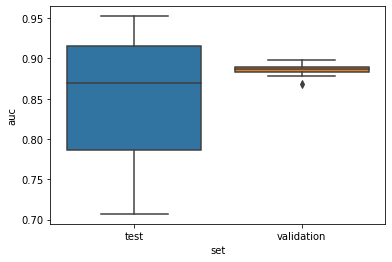

              precision    recall  f1-score   support

           0       0.72      0.63      0.67        67
           1       0.78      0.85      0.81       104

    accuracy                           0.76       171
   macro avg       0.75      0.74      0.74       171
weighted avg       0.76      0.76      0.76       171

0.7602339181286549


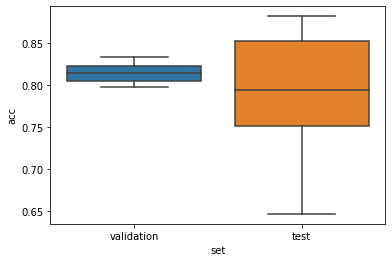

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_kNN = []
results_acc_kNN = []
best_n_neighbors = []
num = 0

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]

    # Hyperparameters that we want to tune.
    leaf_size = list(range(1,50))
    n_neighbors = list(range(1,50))
    p=[1]
    hyperparameters_kNN = dict(n_neighbors=n_neighbors, p=p,leaf_size=leaf_size)

    #Create kNN object
    knn = neighbors.KNeighborsClassifier()

    #Use RandomizedSearch to tune hyperparameters
    random_search_kNN = model_selection.RandomizedSearchCV(knn, hyperparameters_kNN, cv=cv_10fold)

    #Fit the model
    best_model = random_search_kNN.fit(X_validation,y_validation)
    clf = random_search_kNN.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)

    #Print The value of best Hyperparameters
    num = num +1
    print(f'Iteration nr. {num} with best hyperparameters:')
    print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
    print('Best p:', best_model.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])   
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the accuracy
    y_pred_kNN = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(y_validation, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy,'set': 'validation'})
    y_pred_kNN = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results_kNN.append({'auc': auc,'k': clf.n_neighbors,'set': 'test'})       
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results_kNN.append({'auc': auc_validation,'k': clf.n_neighbors,'set': 'validation'})
    
# Create results dataframe and plot it
results_kNN = pd.DataFrame(results_kNN)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_kNN)
plt.show()
results_acc_kNN = pd.DataFrame(results_acc_kNN)
seaborn.boxplot(y='acc', x='set', data=results_acc_kNN)

optimal_n = int(np.median(best_n_neighbors))
#print(f"The optimal N={optimal_n}")

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))

# Support Vector Machine (SVM) Classifier 



Best slack parameter C: 0.5
Best gamma: 1
Best kernel: poly
Best coef0: 1
Best degree: 1
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       269
           1       0.86      0.92      0.89       415

    accuracy                           0.86       684
   macro avg       0.86      0.84      0.85       684
weighted avg       0.86      0.86      0.86       684

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        67
           1       0.82      0.88      0.85       104

    accuracy                           0.81       171
   macro avg       0.80      0.79      0.79       171
weighted avg       0.81      0.81      0.80       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

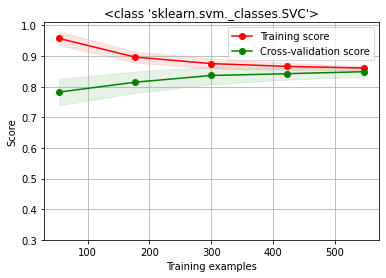

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
 
  
# defining parameter range 
param_grid = {'C': [0.01, 0.5, 1],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.5, 1],
              'degree': [1, 3, 5]}  

# For now: 3 options for kernels implemented: linear rbf and poly
# Other options on kernels:
# - sampler, for example: first use RBF sampler, then linear kernel
# - manually constructed kernel function?
# - precomputed kernel
# - sigmoid kernel


grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold) 
  
# fitting the model for grid search 
best_model = grid.fit(X_train_pca, Y_train) 
clf = grid.best_estimator_


print('Best slack parameter C:', grid.best_estimator_.get_params()['C'])
print('Best gamma:', grid.best_estimator_.get_params()['gamma'])
print('Best kernel:', grid.best_estimator_.get_params()['kernel'])
print('Best coef0:', grid.best_estimator_.get_params()['coef0'])
print('Best degree:', grid.best_estimator_.get_params()['degree'])

# Classification report (training data)
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Classification report (test data)
y_pred_test = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred_test))

# Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)


# SVM with cross-validation

Iteration nr. 1 with best hyperparameters:
Best slack parameter (C): 1
Best gamma: 0.1
Best kernel: rbf
Best coef0: 0.01
Best degree: 3
Iteration nr. 2 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 1.2
Best kernel: linear
Best coef0: 1
Best degree: 1
Iteration nr. 3 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 0.01
Best kernel: linear
Best coef0: 0.01
Best degree: 3
Iteration nr. 4 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 1
Best kernel: linear
Best coef0: 0.01
Best degree: 0.5
Iteration nr. 5 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 1.2
Best kernel: linear
Best coef0: 1
Best degree: 0.5
Iteration nr. 6 with best hyperparameters:
Best slack parameter (C): 0.5
Best gamma: 0.01
Best kernel: linear
Best coef0: 0.5
Best degree: 3
Iteration nr. 7 with best hyperparameters:
Best slack parameter (C): 1
Best gamma: 0.05
Best kernel: rbf
Best coef0: 1
Best degree: 1
Iteration nr. 8 with bes

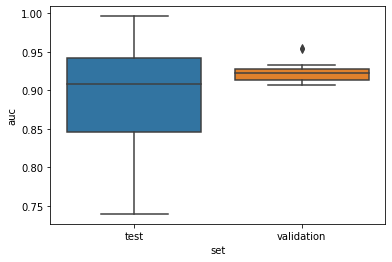

              precision    recall  f1-score   support

           0       0.73      0.69      0.71        67
           1       0.81      0.84      0.82       104

    accuracy                           0.78       171
   macro avg       0.77      0.76      0.76       171
weighted avg       0.78      0.78      0.78       171

0.7777777777777778


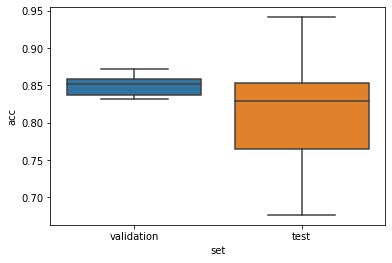

In [0]:
from sklearn.metrics import classification_report

# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_SVM = []
results_acc_SVM = []
best_C = []
best_gamma = []
best_kernel = []
best_coef0 = []
best_degree = []
num = 0

# Program to find most frequent  
# element in a list 
#def most_frequent(List): 
#    return max(set(List), key = List.count) 

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]
    
    
    # Hyperparameters that we want to tune
    param_grid = {'C': [0.01, 0.05, 0.5, 1],  
              'gamma': [1.2, 1, 0.1, 0.05, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.1, 0.5, 1, 1.2],
              'degree': [0.5, 1, 3, 5]}

    # Use RandomizedSearch to tune hyperparameters
    grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold, scoring='roc_auc')  
    
    # Fit the model
    best_model = grid.fit(X_validation, Y_validation)
    clf = grid.best_estimator_

    # Print the value of best hyperparameters
    num = num +1
    print(f'Iteration nr. {num} with best hyperparameters:')
    print(f'Best slack parameter (C): {clf.C}')
    print(f'Best gamma: {clf.gamma}')
    print(f'Best kernel: {clf.kernel}')
    print(f'Best coef0: {clf.coef0}')
    print(f'Best degree: {clf.degree}')

    #best_C.append(clf.C)
    #best_gamma.append(clf.gamma)
    #best_kernel.append(clf.kernel)
    #best_coef0.append(clf.coef0)
    #best_degree.append(clf.degree)
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the accuracy
    Y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_SVM.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, Y_pred)
    results_acc_SVM.append({'acc': accuracy,'set': 'test'})

    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results_SVM.append({'auc': auc,'C': clf.C, 'gamma': clf.gamma, 
                    'kernel': clf.kernel, 'coef0': clf.coef0, 
                    'degree': clf.degree,'set': 'test'})
    
    
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation, scores_validation)
    results_SVM.append({
        'auc': auc_validation,
        'C': clf.C,
        'gamma': clf.gamma,
        'kernel': clf.kernel,
        'coef0': clf.coef0,
        'degree': clf.degree,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results_SVM = pd.DataFrame(results_SVM)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_SVM)
plt.show()
results_acc_SVM = pd.DataFrame(results_acc_SVM)
seaborn.boxplot(y='acc', x='set', data=results_acc_SVM)

#optimal_C = (np.mean(best_C))
#print(f"The optimal C={optimal_C:.1f}")
#optimal_gamma = (np.mean(best_gamma))
#print(f"The optimal gamma={optimal_gamma:.1f}")
#optimal_kernel = (most_frequent(best_kernel)) 
#print(f"The optimal kernel={optimal_kernel}")
#optimal_coef0 = (np.mean(best_coef0))
#print(f"The optimal coef0={optimal_coef0:.1f}")
#optimal_degree = (np.mean(best_degree))
#print(f"The optimal degree={optimal_degree:.1f}")

#grid = SVC(C=round(optimal_C,2), gamma=round(optimal_gamma,2), kernel=optimal_kernel,
          #coef0=round(optimal_coef0,2), degree=round(optimal_degree,2))

# fitting the model for grid search 
# clf = grid.fit(X_train_pca, Y_train) 


print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))


# **Random Forrest Classifier**

The Random Forrest Classifier has 19 different hyperparameters:
- n_estimators: number of trees (to much --> overfitting)
- criterion: How to measure the quality of a split (gini) (tree-specific)
- max_depth: depth of the tree
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: number of samples required to be at a node
- min_weight_fraction_leaf: sum total of the weigths at a node.
- max_features: number of features to consider
- max_leaf_nodes: 
- min_impurity_decrease: node will split if impurity decreases with this value
- min_impurity_split: A node will split if its impurity is above the threshold, otherwise it is a leaf
- bootstrap: use or not (T/F) (To improve accuracy by creating samples)
if T --> max_samples: number of samples to train each base estimator
- oob_score: use out-of-bag samples
- n_jobs: 
- random_state: 
- verbose:
- warm_start:
- class_weight: If one class is more important
- ccp_alpha: x

--> Misschien toevoegen: een tijd segment om te kijken of het niet te lang duurt




Best number of trees: 50
Best Bootstrapping: False
Best criterion: entropy
Best max depth: 8
Best min samples split: 9
Best samples leaf: 6
              precision    recall  f1-score   support

           0       0.99      0.88      0.94       269
           1       0.93      1.00      0.96       415

    accuracy                           0.95       684
   macro avg       0.96      0.94      0.95       684
weighted avg       0.95      0.95      0.95       684

              precision    recall  f1-score   support

           0       0.74      0.52      0.61        67
           1       0.74      0.88      0.81       104

    accuracy                           0.74       171
   macro avg       0.74      0.70      0.71       171
weighted avg       0.74      0.74      0.73       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

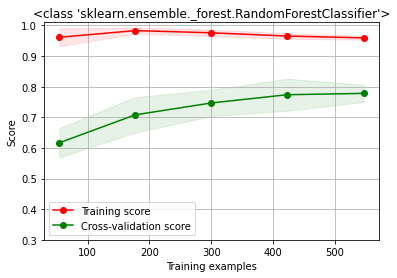

In [0]:
#Hyperparameters tuning:
n_tree = [50]                         # n_estimators
boot = ['True','False']               # Bootstrapping
criterion = ['gini','entropy']        # measure of quality
max_depth = list(range(5,16))         # Depth of the tree
min_samples_split = list(range(2,10)) # prevends overfitting
min_samples_leaf = [3,4,5,6,7]        # prevends overfitting


param_grid = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=False, cv=cv_10fold) 
  
# fitting the model for grid search 
best_model = grid.fit(X_train_pca, Y_train) 
clf = grid.best_estimator_

print('Best number of trees:', grid.best_estimator_.get_params()['n_estimators'])
print('Best Bootstrapping:', grid.best_estimator_.get_params()['bootstrap'])
print('Best criterion:', grid.best_estimator_.get_params()['criterion'])
print('Best max depth:', grid.best_estimator_.get_params()['max_depth'])
print('Best min samples split:', grid.best_estimator_.get_params()['min_samples_split'])
print('Best samples leaf:', grid.best_estimator_.get_params()['min_samples_leaf'])

# Classification report (training data)
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Classification report (test data)
y_pred_test = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred_test))

#Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)


# **Random Forrest with Crossvalidation**



Best number of trees: 50
Best Bootstrapping: True
Best criterion: entropy
Best max depth: 11
Best min samples split: 2
Best samples leaf: 4
Best number of trees: 50
Best Bootstrapping: False
Best criterion: gini
Best max depth: 11
Best min samples split: 5
Best samples leaf: 5
Best number of trees: 50
Best Bootstrapping: True
Best criterion: gini
Best max depth: 8
Best min samples split: 8
Best samples leaf: 7
Best number of trees: 50
Best Bootstrapping: True
Best criterion: gini
Best max depth: 11
Best min samples split: 8
Best samples leaf: 7
Best number of trees: 50
Best Bootstrapping: False
Best criterion: gini
Best max depth: 8
Best min samples split: 4
Best samples leaf: 7
Best number of trees: 50
Best Bootstrapping: False
Best criterion: gini
Best max depth: 10
Best min samples split: 5
Best samples leaf: 7
Best number of trees: 50
Best Bootstrapping: False
Best criterion: entropy
Best max depth: 8
Best min samples split: 6
Best samples leaf: 3
Best number of trees: 50
Best Boot

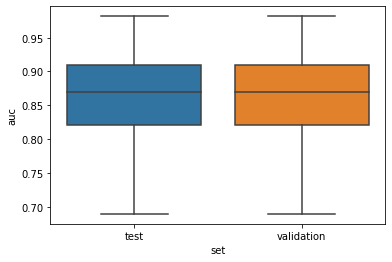

The optimal number of trees=50.0
The optimal bootstrap=False
The optimal criterion=entropy
The optimal max depth=10.6
The optimal min samples split=5.7
The optimal min samples leaf=5.5
              precision    recall  f1-score   support

           0       0.70      0.55      0.62        67
           1       0.75      0.85      0.79       104

    accuracy                           0.73       171
   macro avg       0.72      0.70      0.70       171
weighted avg       0.73      0.73      0.72       171

0.7309941520467836


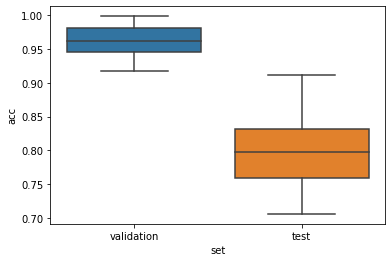

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_RF = []
results_acc_RF = []
Best_n_trees = []
Best_Bootstrapping = []
Best_criterion = []
Best_max_depth = []
Best_min_samples_split = []
Best_min_samples_leaf = []

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test_RF = X_train_pca[test_index]
    Y_test_RF = np.array(Y_train)[test_index]
    
    param_grid = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

    grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, 
                              verbose=False, cv=cv_10fold)
    
    best_model = grid.fit(X_validation, Y_validation)
    
    # Get resulting classifier
    clf = grid.best_estimator_
    print(f'Best number of trees: {clf.n_estimators}')
    print(f'Best Bootstrapping: {clf.bootstrap}')
    print(f'Best criterion: {clf.criterion}')
    print(f'Best max depth: {clf.max_depth}')
    print(f'Best min samples split: {clf.min_samples_split}')
    print(f'Best samples leaf: {clf.min_samples_leaf}')

    Best_n_trees.append(clf.n_estimators)
    Best_Bootstrapping.append(clf.bootstrap)
    Best_criterion.append(clf.criterion)
    Best_max_depth.append(clf.max_depth)
    Best_min_samples_split.append(clf.min_samples_split)
    Best_min_samples_leaf.append(clf.min_samples_leaf)

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_RF)
    scores = probabilities[:, 1]

    # Get the accuracy
    Y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf.predict(X_test_RF)
    accuracy = metrics.accuracy_score(Y_test_RF, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_test_RF, scores)
    results_RF.append({'auc': auc,'n_estimators': clf.n_estimators, 
                    'bootstrap': clf.bootstrap, 
                    'criterion': clf.criterion, 
                    'max_depth': clf.max_depth, 
                    'min_samples_split': clf.min_samples_split, 
                    'min_samples_split': clf.min_samples_leaf,
                    'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation, scores_validation)
    results_RF.append({
        'auc': auc,'n_estimators': clf.n_estimators, 
        'bootstrap': clf.bootstrap, 
        'criterion': clf.criterion, 
        'max_depth': clf.max_depth, 
        'min_samples_split': clf.min_samples_split, 
        'min_samples_leaf': clf.min_samples_leaf,
        'set': 'validation'
        })
    
# Create results dataframe and plot it
results_RF = pd.DataFrame(results_RF)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_RF)
plt.show()
results_acc_RF = pd.DataFrame(results_acc_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_RF)

optimal_n_tree = (np.mean(Best_n_trees))
print(f"The optimal number of trees={optimal_n_tree:.1f}")
optimal_bootstrap = (most_frequent(Best_Bootstrapping))
print(f"The optimal bootstrap={optimal_bootstrap}")
optimal_criterion = (most_frequent(Best_criterion)) 
print(f"The optimal criterion={optimal_criterion}")
optimal_max_depth = (np.mean(Best_max_depth))
print(f"The optimal max depth={optimal_max_depth:.1f}")
optimal_min_samples_split = (np.mean(Best_min_samples_split))
print(f"The optimal min samples split={optimal_min_samples_split:.1f}")
optimal_min_samples_leaf = (np.mean(Best_min_samples_leaf))
print(f"The optimal min samples leaf={optimal_min_samples_leaf:.1f}")

grid = RandomForestClassifier(n_estimators=int(round(optimal_n_tree)), 
                              bootstrap=optimal_bootstrap, 
                              criterion=optimal_criterion, 
                              max_depth=int(round(optimal_max_depth)), 
                              min_samples_split=int(round(optimal_min_samples_split)), 
                              min_samples_leaf=int(round(optimal_min_samples_leaf)))

# fitting the model for grid search 
clf = grid.fit(X_train_pca, Y_train) 

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))

# **Combined Cross Validation With Voting**




In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
# Lists for KNN
results_kNN = []
results_acc_kNN = []
best_n_neighbors = []
num = 0

# Lists for SVM
results_SVM = []
results_acc_SVM = []
best_C = []
best_gamma = []
best_kernel = []
best_coef0 = []
best_degree = []

# Lists for RF
results_RF = []
results_acc_RF = []
Best_n_trees = []
Best_Bootstrapping = []
Best_criterion = []
Best_max_depth = []
Best_min_samples_split = []
Best_min_samples_leaf = []

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 

# Loop over the folds (KNN)
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]

    # Hyperparameters that we want to tune. (KNN)
    leaf_size = list(range(1,50))
    n_neighbors = list(range(1,50))
    p=[1]
    hyperparameters_kNN = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)

    #Create kNN object
    knn = neighbors.KNeighborsClassifier()

    #Use RandomizedSearch to tune hyperparameters
    random_search_kNN = model_selection.RandomizedSearchCV(knn, hyperparameters_kNN, cv=cv_10fold)

    #Fit the model
    best_model = random_search_kNN.fit(X_validation,y_validation)
    clf = random_search_kNN.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)

    #Print The value of best Hyperparameters
    num = num +1
    print(f'Iteration nr. {num} with best hyperparameters:')
    print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
    print('Best p:', best_model.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])   
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the accuracy
    y_pred_kNN = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(y_validation, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy,'set': 'validation'})
    y_pred_kNN = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results_kNN.append({'auc': auc,'k': clf.n_neighbors,'set': 'test'})       
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results_kNN.append({'auc': auc_validation,'k': clf.n_neighbors,'set': 'validation'})
    
# Loop over the folds (SVM)
# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]
    
    
    # Same as above
    param_grid = {'C': [0.01, 0.05, 0.5, 1],  
              'gamma': [1.2, 1, 0.1, 0.05, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.1, 0.5, 1, 1.2],
              'degree': [0.5, 1, 3, 5]}
    grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold, scoring='roc_auc')  
    best_model = grid.fit(X_validation, Y_validation)

    
    # Get resulting classifier
    clf = grid.best_estimator_
    print(f'Best slack parameter: C={clf.C}')
    print(f'Best gamma: gamma={clf.gamma}')
    print(f'Best kernel: kernel={clf.kernel}')
    print(f'Best coef0: coef0={clf.coef0}')
    print(f'Best degree: degree={clf.degree}')

    best_C.append(clf.C)
    best_gamma.append(clf.gamma)
    best_kernel.append(clf.kernel)
    best_coef0.append(clf.coef0)
    best_degree.append(clf.degree)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the accuracy
    Y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_SVM.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, Y_pred)
    results_acc_SVM.append({'acc': accuracy,'set': 'test'})

    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results_SVM.append({'auc': auc,'C': clf.C, 'gamma': clf.gamma, 
                    'kernel': clf.kernel, 'coef0': clf.coef0, 
                    'degree': clf.degree,'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation, scores_validation)
    results_SVM.append({
        'auc': auc_validation,
        'C': clf.C,
        'gamma': clf.gamma,
        'kernel': clf.kernel,
        'coef0': clf.coef0,
        'degree': clf.degree,
        'set': 'validation'
    })
    
# Loop over the folds (RF)
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test_RF = X_train_pca[test_index]
    Y_test_RF = np.array(Y_train)[test_index]
    
    param_grid = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

    grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, 
                              verbose=False, cv=cv_10fold)
    
    best_model = grid.fit(X_validation, Y_validation)
    
    # Get resulting classifier
    clf = grid.best_estimator_
    print(f'Best number of trees: {clf.n_estimators}')
    print(f'Best Bootstrapping: {clf.bootstrap}')
    print(f'Best criterion: {clf.criterion}')
    print(f'Best max depth: {clf.max_depth}')
    print(f'Best min samples split: {clf.min_samples_split}')
    print(f'Best samples leaf: {clf.min_samples_leaf}')

    Best_n_trees.append(clf.n_estimators)
    Best_Bootstrapping.append(clf.bootstrap)
    Best_criterion.append(clf.criterion)
    Best_max_depth.append(clf.max_depth)
    Best_min_samples_split.append(clf.min_samples_split)
    Best_min_samples_leaf.append(clf.min_samples_leaf)

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_RF)
    scores = probabilities[:, 1]

    # Get the accuracy
    Y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf.predict(X_test_RF)
    accuracy = metrics.accuracy_score(Y_test_RF, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_test_RF, scores)
    results_RF.append({'auc': auc,'n_estimators': clf.n_estimators, 
                    'bootstrap': clf.bootstrap, 
                    'criterion': clf.criterion, 
                    'max_depth': clf.max_depth, 
                    'min_samples_split': clf.min_samples_split, 
                    'min_samples_split': clf.min_samples_leaf,
                    'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation, scores_validation)
    results_RF.append({
        'auc': auc,'n_estimators': clf.n_estimators, 
        'bootstrap': clf.bootstrap, 
        'criterion': clf.criterion, 
        'max_depth': clf.max_depth, 
        'min_samples_split': clf.min_samples_split, 
        'min_samples_leaf': clf.min_samples_leaf,
        'set': 'validation'
        })
    

# Plot all results
# Create results dataframe and plot it (KNN)
results_kNN = pd.DataFrame(results_kNN)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_kNN)
plt.show()
results_acc_kNN = pd.DataFrame(results_acc_kNN)
seaborn.boxplot(y='acc', x='set', data=results_acc_kNN)

optimal_n = int(np.median(best_n_neighbors))
#print(f"The optimal N={optimal_n}")

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))


# Create results dataframe and plot it (SVM)
results_SVM = pd.DataFrame(results_SVM)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_SVM)
plt.show()
results_acc_SVM = pd.DataFrame(results_acc_SVM)
seaborn.boxplot(y='acc', x='set', data=results_acc_SVM)

optimal_C = (np.mean(best_C))
print(f"The optimal C={optimal_C:.1f}")
optimal_gamma = (np.mean(best_gamma))
print(f"The optimal gamma={optimal_gamma:.1f}")
optimal_kernel = (most_frequent(best_kernel)) 
print(f"The optimal kernel={optimal_kernel}")
optimal_coef0 = (np.mean(best_coef0))
print(f"The optimal coef0={optimal_coef0:.1f}")
optimal_degree = (np.mean(best_degree))
print(f"The optimal degree={optimal_degree:.1f}")

grid = SVC(C=round(optimal_C,2), gamma=round(optimal_gamma,2), kernel=optimal_kernel,
          coef0=round(optimal_coef0,2), degree=round(optimal_degree,2))

# fitting the model for grid search 
clf = grid.fit(X_train_pca, Y_train) 

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))


# Create results dataframe and plot it (RF)
results_RF = pd.DataFrame(results_RF)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_RF)
plt.show()
results_acc_RF = pd.DataFrame(results_acc_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_RF)

optimal_n_tree = (np.mean(Best_n_trees))
print(f"The optimal number of trees={optimal_n_tree:.1f}")
optimal_bootstrap = (most_frequent(Best_Bootstrapping))
print(f"The optimal bootstrap={optimal_bootstrap}")
optimal_criterion = (most_frequent(Best_criterion)) 
print(f"The optimal criterion={optimal_criterion}")
optimal_max_depth = (np.mean(Best_max_depth))
print(f"The optimal max depth={optimal_max_depth:.1f}")
optimal_min_samples_split = (np.mean(Best_min_samples_split))
print(f"The optimal min samples split={optimal_min_samples_split:.1f}")
optimal_min_samples_leaf = (np.mean(Best_min_samples_leaf))
print(f"The optimal min samples leaf={optimal_min_samples_leaf:.1f}")

grid = RandomForestClassifier(n_estimators=int(round(optimal_n_tree)), 
                              bootstrap=optimal_bootstrap, 
                              criterion=optimal_criterion, 
                              max_depth=int(round(optimal_max_depth)), 
                              min_samples_split=int(round(optimal_min_samples_split)), 
                              min_samples_leaf=int(round(optimal_min_samples_leaf)))

# fitting the model for grid search 
clf = grid.fit(X_train_pca, Y_train) 

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))


50


In [0]:
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
print (cv_20fold)

StratifiedKFold(n_splits=20, random_state=None, shuffle=False)
